Steps:

1. Load the data.
2. Cast text to lower case.
3. Eliminate punctuation.
4. Get the maximum number of tokens in the data.
5. Tokenize the data.

In [1]:
import os
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

from unidecode import unidecode
from sklearn.metrics import accuracy_score

from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary

from jupyterthemes import jtplot

In [2]:
jtplot.style("gruvboxd")

In [3]:
torch.autograd.set_detect_anomaly(True)

In [ ]:
### Reproducibility
torch.manual_seed(42)
os.environ['PYTHONHASHSEED'] = str(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
print(device)

cuda


In [6]:
DATA_PATH = os.path.join(os.getcwd().replace('notebooks', 'data'), 'train.csv')
data = pd.read_csv(DATA_PATH)

In [7]:
data.head()

,lyric,class
0,Can't drink without thinkin' about you,1
1,Now Lil Pump flyin' private jet (Yuh),0
2,"No, matter fact, you ain't help me when I had ...",0
3,"And you could find me, I ain't hidin'",0
4,From the way you talk to the way you move,1


In [8]:
data['lyric'] = data['lyric'].str.lower()

In [9]:
data.head()

,lyric,class
0,can't drink without thinkin' about you,1
1,now lil pump flyin' private jet (yuh),0
2,"no, matter fact, you ain't help me when i had ...",0
3,"and you could find me, i ain't hidin'",0
4,from the way you talk to the way you move,1


In [10]:
def clear_punctuation(text):
    text = ''.join([char for char in text if char not in all_punct])
    return text

In [11]:
all_char = string.ascii_lowercase

In [12]:
all_char

'abcdefghijklmnopqrstuvwxyz'

In [13]:
all_punct = string.punctuation

In [14]:
all_punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
data['lyric'] = data['lyric'].apply(clear_punctuation)

In [16]:
data.head()

,lyric,class
0,cant drink without thinkin about you,1
1,now lil pump flyin private jet yuh,0
2,no matter fact you aint help me when i had no ...,0
3,and you could find me i aint hidin,0
4,from the way you talk to the way you move,1


In [17]:
data['lyric_len'] = data['lyric'].apply(len)

In [18]:
data.head()

,lyric,class,lyric_len
0,cant drink without thinkin about you,1,36
1,now lil pump flyin private jet yuh,0,34
2,no matter fact you aint help me when i had no ...,0,51
3,and you could find me i aint hidin,0,34
4,from the way you talk to the way you move,1,41


In [19]:
data.loc[data['lyric_len'] == max(data['lyric_len'])]

,lyric,class,lyric_len
41158,although the recent concerts of some of the bi...,0,345


In [20]:
for row in data.iterrows():
    print(row[1])
    break

lyric        cant drink without thinkin about you
class                                           1
lyric_len                                      36
Name: 0, dtype: object


The length of the texts are not symmetrical, so we need to pad the text.

In [21]:
def pad_text(text, unk = '?', limit = 400):
    if len(text) < limit:
        text = text + unk*(limit - len(text))
    else:
        text = text[:limit-1]
    return text

In [22]:
data['lyric'] = data['lyric'].apply(pad_text, **{"limit" : 400, "unk" : "#"})

In [23]:
data.head()

,lyric,class,lyric_len
0,cant drink without thinkin about you##########...,1,36
1,now lil pump flyin private jet yuh############...,0,34
2,no matter fact you aint help me when i had no ...,0,51
3,and you could find me i aint hidin############...,0,34
4,from the way you talk to the way you move#####...,1,41


In [24]:
unidecode(data['lyric'][0])

'cant drink without thinkin about you############################################################################################################################################################################################################################################################################################################################################################################'

In [25]:
all_char = '#' + ' ' + all_char + ''.join([str(n) for n in range(10)])

In [26]:
all_char

'# abcdefghijklmnopqrstuvwxyz0123456789'

In [27]:
char_dict = dict(enumerate(all_char, start = 0))
char_dict = {v: k for k, v in char_dict.items()}

In [28]:
char_dict

{'#': 0,
 ' ': 1,
 'a': 2,
 'b': 3,
 'c': 4,
 'd': 5,
 'e': 6,
 'f': 7,
 'g': 8,
 'h': 9,
 'i': 10,
 'j': 11,
 'k': 12,
 'l': 13,
 'm': 14,
 'n': 15,
 'o': 16,
 'p': 17,
 'q': 18,
 'r': 19,
 's': 20,
 't': 21,
 'u': 22,
 'v': 23,
 'w': 24,
 'x': 25,
 'y': 26,
 'z': 27,
 '0': 28,
 '1': 29,
 '2': 30,
 '3': 31,
 '4': 32,
 '5': 33,
 '6': 34,
 '7': 35,
 '8': 36,
 '9': 37}

In [29]:
class TextDataset(Dataset):
    def __init__(self, file):
        self.file = file
        self.texts = self.file['lyric']
        self.labels = self.file['class']
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, ix):
        return torch.tensor([char_dict[c] for c in self.texts[ix]]), self.labels[ix]

In [30]:
text_data = TextDataset(data)

In [31]:
len(text_data)

51054

In [32]:
text_data.texts

0        cant drink without thinkin about you##########...
1        now lil pump flyin private jet yuh############...
2        no matter fact you aint help me when i had no ...
3        and you could find me i aint hidin############...
4        from the way you talk to the way you move#####...
                               ...                        
51049    i told her pour me some more then she went rig...
51050    hit the ground and crawl to the dresser#######...
51051    just keep breathin and breathin and breathin a...
51052    down go the system long live the king king####...
51053    if your mother knew all the things we do from ...
Name: lyric, Length: 51054, dtype: object

In [33]:
next(iter(text_data))

(tensor([ 4,  2, 15, 21,  1,  5, 19, 10, 15, 12,  1, 24, 10, 21,  9, 16, 22, 21,
          1, 21,  9, 10, 15, 12, 10, 15,  1,  2,  3, 16, 22, 21,  1, 26, 16, 22,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,

In [34]:
char_dict['3']

31

In [35]:
BATCH_SIZE = 32
SEQ_LEN = 256
HIDDEN_SIZE = 256
TEST_SIZE = 6000

In [36]:
train_ds, test_ds = torch.utils.data.random_split(text_data, lengths = [len(text_data) - TEST_SIZE, TEST_SIZE])

In [37]:
len(train_ds)

45054

In [38]:
len(test_ds)

6000

In [39]:
train_dl = DataLoader(train_ds, batch_size = BATCH_SIZE, drop_last = True, shuffle = True)

In [40]:
test_dl = DataLoader(test_ds, batch_size = BATCH_SIZE, drop_last = True, shuffle = True)

In [41]:
class LyricModel(nn.Module):
    def __init__(self, batch_size = 32, num_layers = 2, bidirectional = True, hidden_size = 128, embedding_dim = 64):
        super(LyricModel, self).__init__()
        
        self.hidden = hidden_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.in_features = self.hidden * (int(self.bidirectional) + 1)
        
        self.embedder = nn.Embedding(num_embeddings = len(char_dict), embedding_dim = self.embedding_dim)
        
        self.lstm = nn.LSTM(input_size = self.embedding_dim, hidden_size = self.hidden, batch_first = True,
                            num_layers = self.num_layers, bidirectional = self.bidirectional)
        self.dropout = nn.Dropout(p = 0.1)
        
        self.linear1 = nn.Linear(self.in_features, self.in_features//2)
        self.linear2 = nn.Linear(self.in_features//2, 64)
        self.linear3 = nn.Linear(64, 1)
        
        self.b1 = nn.BatchNorm1d(self.in_features//2, momentum = 0.1)
        self.b2 = nn.BatchNorm1d(64, momentum = 0.1)
        
    def forward(self, x, state):
        x = self.embedder(x)
        y, (h, c) = self.lstm(x, state)
        
        last_output = y[:, -1, :].contiguous().view(-1, self.in_features)
        last_output = self.dropout(last_output)
        
        y = F.leaky_relu(self.linear1(last_output), .1)
        y = self.b1(y)
        y = F.leaky_relu(self.linear2(y), .1)
        y = self.b2(y)
        y = self.linear3(y).squeeze()
        
        return torch.sigmoid(y), (h, c)
    
    def init_hidden_state(self, mean, stddev):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample(((int(self.bidirectional) + 1)*self.num_layers,\
                                                             self.batch_size, self.hidden))
        c = torch.distributions.Normal(mean, stddev).sample(((int(self.bidirectional) + 1)*self.num_layers, \
                                                             self.batch_size, self.hidden))
        
        return (h.to(device), c.to(device))

In [42]:
def initialize_weights(model):
    for layer in model.modules():
        if layer.__class__.__name__.__contains__('Linear'):
            nn.init.normal_(layer.weight.data, 1, 0.02)
            nn.init.normal_(layer.bias.data, 0, 0.02)
        elif layer.__class__.__name__.__contains__('LSTM'):
            for param in layer.parameters():
                nn.init.normal_(param.data, 0, 0.2)
        else:
            pass
    return None

In [43]:
model = LyricModel(num_layers = 1, hidden_size = HIDDEN_SIZE, embedding_dim = SEQ_LEN)
model.to(device)

LyricModel(
  (embedder): Embedding(38, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (b1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [44]:
x, h = [torch.randint(low = 0, high = 10, size = (32, SEQ_LEN)).to(device),
        (torch.randn(2, 32, 256).to(device), torch.randn(2, 32, 256).to(device))]

In [45]:
### Model summary
summary(model, input_data = [x, h])

Layer (type:depth-idx)                   Output Shape              Param #
LyricModel                               [32]                      --
├─Embedding: 1-1                         [32, 256, 256]            9,728
├─LSTM: 1-2                              [32, 256, 512]            1,052,672
├─Dropout: 1-3                           [32, 512]                 --
├─Linear: 1-4                            [32, 256]                 131,328
├─BatchNorm1d: 1-5                       [32, 256]                 512
├─Linear: 1-6                            [32, 64]                  16,448
├─BatchNorm1d: 1-7                       [32, 64]                  128
├─Linear: 1-8                            [32, 1]                   65
Total params: 1,210,881
Trainable params: 1,210,881
Non-trainable params: 0
Total mult-adds (G): 8.63
Input size (MB): 0.20
Forward/backward pass size (MB): 50.50
Params size (MB): 4.84
Estimated Total Size (MB): 55.54

In [46]:
for name, param in model.named_parameters():
    print(f"Param {name}, shape: {param.data.shape}")

Param embedder.weight, shape: torch.Size([38, 256])
Param lstm.weight_ih_l0, shape: torch.Size([1024, 256])
Param lstm.weight_hh_l0, shape: torch.Size([1024, 256])
Param lstm.bias_ih_l0, shape: torch.Size([1024])
Param lstm.bias_hh_l0, shape: torch.Size([1024])
Param lstm.weight_ih_l0_reverse, shape: torch.Size([1024, 256])
Param lstm.weight_hh_l0_reverse, shape: torch.Size([1024, 256])
Param lstm.bias_ih_l0_reverse, shape: torch.Size([1024])
Param lstm.bias_hh_l0_reverse, shape: torch.Size([1024])
Param linear1.weight, shape: torch.Size([256, 512])
Param linear1.bias, shape: torch.Size([256])
Param linear2.weight, shape: torch.Size([64, 256])
Param linear2.bias, shape: torch.Size([64])
Param linear3.weight, shape: torch.Size([1, 64])
Param linear3.bias, shape: torch.Size([1])
Param b1.weight, shape: torch.Size([256])
Param b1.bias, shape: torch.Size([256])
Param b2.weight, shape: torch.Size([64])
Param b2.bias, shape: torch.Size([64])


In [47]:
model = LyricModel(num_layers = 1, hidden_size = HIDDEN_SIZE, embedding_dim = SEQ_LEN)
model.to(device)

LyricModel(
  (embedder): Embedding(38, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (b1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [48]:
model.to(device)
model.apply(initialize_weights)

LyricModel(
  (embedder): Embedding(38, 256)
  (lstm): LSTM(256, 256, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear1): Linear(in_features=512, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (b1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (b2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [49]:
EPOCHS = 100
lr = 1e-4
betas = (0.5, 0.999)

In [50]:
opt = optim.Adam(params = model.parameters(), lr = lr, betas = betas)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, 1200)
criterion = nn.BCELoss().to(device)

In [51]:
writer = SummaryWriter(log_dir = "runs/test")

In [52]:
writer.add_graph(model = model, input_to_model = (x, h))

In [53]:
model.zero_grad()

In [54]:
TRAIN_DATA_LEN = len(train_dl)
TEST_DATA_LEN = len(test_dl)

print(f"Training for {EPOCHS} epochs and {TRAIN_DATA_LEN} training iterations...\n")

train_loss_epoch = []
test_loss_epoch = []

train_acc_epoch = []
test_acc_epoch = []

train_loss = []
test_loss = []

train_acc = []
test_acc = []

for epoch in range(1, EPOCHS + 1):
    state = model.init_hidden_state(0,1)
    train_loss.clear()
    test_loss.clear()
    
    train_acc.clear()
    test_acc.clear()
    
    model.train()
    for i, (X, y) in enumerate(train_dl, start = 1):
        opt.zero_grad()
        X, y = X.to(device), y.to(device)
        state = tuple([each.data for each in state])
        
        y_pred, new_state = model(X, state)
        
        loss = criterion(y_pred, y.float())
        loss.backward()
        
        opt.step()
        
        acc = accuracy_score(y.cpu().numpy(), torch.where(y_pred.detach() >= 0.5, 1, 0).cpu().numpy())
        
        train_loss.append(loss.item())
        train_acc.append(acc)
        state = new_state

    with torch.inference_mode():
        model.eval()
        state_ = model.init_hidden_state(0, 1)
        
        for i, (X_, y_) in enumerate(test_dl, start = 1):
            X_, y_ = X_.to(device), y_.to(device)
            state_ = tuple([each.data for each in state_])
            y_pred, new_state = model(X_, state_)
            
            loss = criterion(y_pred, y_.float())
            acc = accuracy_score(y_.cpu().numpy(), torch.where(y_pred.detach() >= 0.5, 1, 0).cpu().numpy())
            test_loss.append(loss.item())
            test_acc.append(acc)
            state_ = new_state

    ### Training metrics
    train_loss_final = sum(train_loss)/len(train_loss)
    train_acc_final = sum(train_acc)/len(train_acc)

    train_loss_epoch.append(train_loss_final)
    train_acc_epoch.append(train_acc_final)

    ### Test metrics
    test_loss_final = sum(test_loss)/len(test_loss)
    test_acc_final = sum(test_acc)/len(test_acc)

    test_loss_epoch.append(test_loss_final)
    test_acc_epoch.append(test_acc_final)
    
    scheduler.step()

    ### Print diagnostics
    print(f"Epoch [{epoch: 2d}/{EPOCHS}]")
    print(f"   Train loss: {train_loss_final: .3f} || Test loss: {test_loss_final: .3f}")
    print(f"   Train acc.: {train_acc_final: .3f} || Test acc.: {test_acc_final: .3f}\n")
    

Training for 100 epochs and 1407 training iterations...

Epoch [ 1/100]
   Train loss:  13.285 || Test loss:  5.357
   Train acc.:  0.543 || Test acc.:  0.556

Epoch [ 2/100]
   Train loss:  7.555 || Test loss:  5.907
   Train acc.:  0.524 || Test acc.:  0.554

Epoch [ 3/100]
   Train loss:  6.912 || Test loss:  5.635
   Train acc.:  0.498 || Test acc.:  0.553

Epoch [ 4/100]
   Train loss:  6.305 || Test loss:  4.153
   Train acc.:  0.496 || Test acc.:  0.531

Epoch [ 5/100]
   Train loss:  5.616 || Test loss:  4.418
   Train acc.:  0.502 || Test acc.:  0.480

Epoch [ 6/100]
   Train loss:  5.267 || Test loss:  4.741
   Train acc.:  0.504 || Test acc.:  0.498

Epoch [ 7/100]
   Train loss:  4.464 || Test loss:  2.914
   Train acc.:  0.501 || Test acc.:  0.544

Epoch [ 8/100]
   Train loss:  4.191 || Test loss:  2.894
   Train acc.:  0.501 || Test acc.:  0.557

Epoch [ 9/100]
   Train loss:  3.960 || Test loss:  2.876
   Train acc.:  0.500 || Test acc.:  0.472

Epoch [ 10/100]
   Train

Epoch [ 81/100]
   Train loss:  0.157 || Test loss:  0.511
   Train acc.:  0.962 || Test acc.:  0.843

Epoch [ 82/100]
   Train loss:  0.158 || Test loss:  0.538
   Train acc.:  0.962 || Test acc.:  0.842

Epoch [ 83/100]
   Train loss:  0.160 || Test loss:  0.505
   Train acc.:  0.961 || Test acc.:  0.847

Epoch [ 84/100]
   Train loss:  0.155 || Test loss:  0.555
   Train acc.:  0.963 || Test acc.:  0.839

Epoch [ 85/100]
   Train loss:  0.157 || Test loss:  0.593
   Train acc.:  0.961 || Test acc.:  0.829

Epoch [ 86/100]
   Train loss:  0.187 || Test loss:  0.494
   Train acc.:  0.950 || Test acc.:  0.832

Epoch [ 87/100]
   Train loss:  0.162 || Test loss:  0.555
   Train acc.:  0.960 || Test acc.:  0.835

Epoch [ 88/100]
   Train loss:  0.150 || Test loss:  0.518
   Train acc.:  0.965 || Test acc.:  0.845

Epoch [ 89/100]
   Train loss:  0.156 || Test loss:  0.524
   Train acc.:  0.962 || Test acc.:  0.839

Epoch [ 90/100]
   Train loss:  0.151 || Test loss:  0.531
   Train acc.:

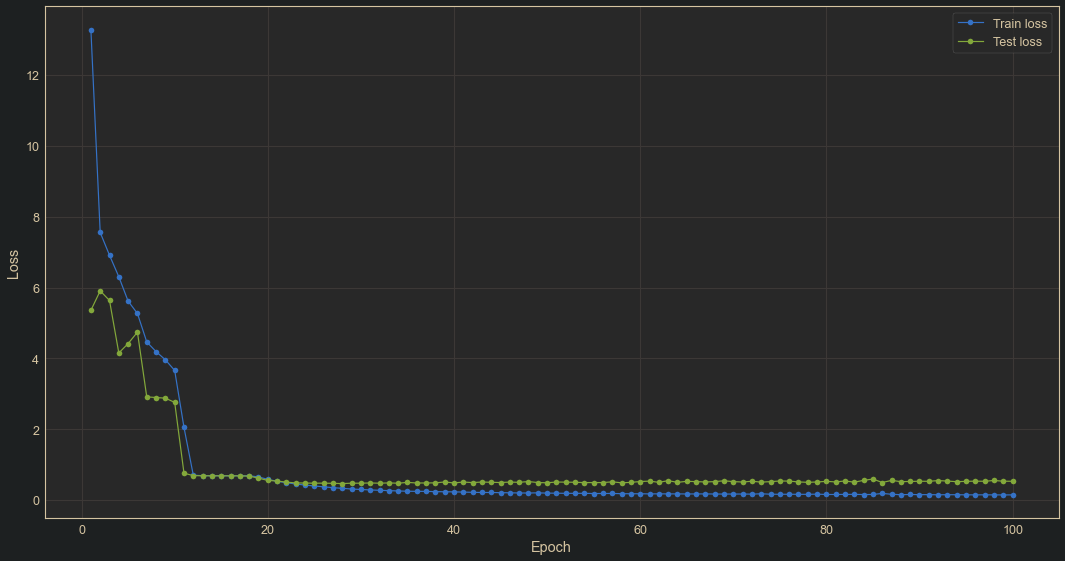

In [55]:
plt.figure(figsize = (15, 8))
plt.plot(range(1, EPOCHS + 1), train_loss_epoch, label = 'Train loss', marker = 'o')
plt.plot(range(1, EPOCHS + 1), test_loss_epoch, label = 'Test loss', marker = 'o')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.tight_layout()

plt.show(); plt.close('all')

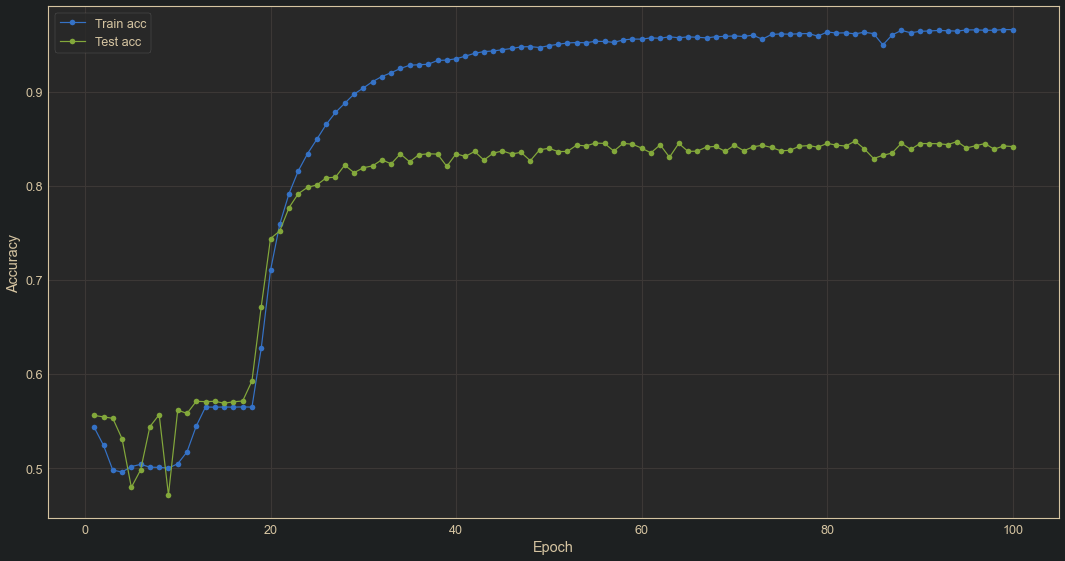

In [56]:
plt.figure(figsize = (15, 8))
plt.plot(range(1, EPOCHS + 1), train_acc_epoch, label = 'Train acc', marker = 'o')
plt.plot(range(1, EPOCHS + 1), test_acc_epoch, label = 'Test acc', marker = 'o')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()
plt.tight_layout()

plt.show(); plt.close('all')

In [57]:
MODEL_NAME = "saved-lstm-model.ckpt"
torch.save(model.state_dict(), MODEL_NAME)